SIIM-ACR PNEUMOTHORAX SEGMENTATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
# import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

import torch.nn.functional as F
import torchvision.transforms.functional as TF
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import Sampler
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

try:
    from itertools import ifilterfalse
except ImportError:  # py3k
    from itertools import filterfalse

# import segmentation_models_pytorch as smp
# import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
#from Losses import ComboLoss, dice_metric

## Losses

In [ ]:
eps = 1e-6


def soft_dice_loss(outputs, targets, per_image=False, per_channel=False):
    batch_size, n_channels = outputs.size(0), outputs.size(1)

    eps = 1e-6
    n_parts = 1
    if per_image:
        n_parts = batch_size
    if per_channel:
        n_parts = batch_size * n_channels

    dice_target = targets.contiguous().view(n_parts, -1).float()
    dice_output = outputs.contiguous().view(n_parts, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = (1 - (2 * intersection + eps) / union).mean()
    return loss

def dice_metric(preds, trues, per_image=False, per_channel=False):
    preds = preds.float()
    return 1 - soft_dice_loss(preds, trues, per_image, per_channel)


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        return soft_dice_loss(input, target, per_image=self.per_image)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)


class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, input, target):
        input = input.float().view(-1)
        target = target.float().view(-1)
        neg_abs = - input.abs()
        # todo check correctness
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=False, channel_weights=[1, 0.5, 0.5], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=False)
        self.jaccard = JaccardLoss(per_image=False)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
                                               targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss.clamp(min=1e-5)


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss

def symmetric_lovasz(outputs, targets, ):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return symmetric_lovasz(outputs, targets)

class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)


class FocalLoss2d(nn.Module):
    def __init__(self, gamma=2, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        eps = 1e-8
        non_ignored = targets.view(-1) != self.ignore_index
        targets = targets.view(-1)[non_ignored].float()
        outputs = outputs.contiguous().view(-1)[non_ignored]
        outputs = torch.clamp(outputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        return (-(1. - pt) ** self.gamma * torch.log(pt)).mean()

## Config

The [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) function used in CRITERION below also comes from the winning solution by Anuar.

In [ ]:
IMG_SIZE         = 512
DIR              = "/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/train_png"
DATA_DIR         = Path(DIR)
TRAIN_IMG_DIR    = Path(DIR)
TRAIN_LBL_DIR    = Path("/content/drive/MyDrive/Colab_Notebooks/datasets/mask")
# RLE_DF           = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/siim_acr_dicom/train-rle.csv", names=['ImageId', 'EncodedPixels'], skiprows=1)
KFOLD_PATH       = ''
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
BATCH_SIZE       = 8
USE_SAMPLER      = False
POSTIVE_PERC     = 0.8
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
PRETRAINED       = False # modified
LEARNING_RATE    = 0.0001
EPOCHS           = 1 #default was 5
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = True # modified
EVALUATE         = True # modified
FOLD_ID          = 4
prediction_path  = "/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/Predicted_masks/tests"


## Utils

General utility functions.

In [ ]:
# def run_length_decode(rle, height=1024, width=1024, fill_value=1):
#     component = np.zeros((height, width), np.float32)
#     component = component.reshape(-1)
#     rle = np.array([int(s) for s in rle.strip().split(' ')])
#     rle = rle.reshape(-1, 2)
#     start = 0
#     for index, length in rle:
#         start = start+index
#         end = start+length
#         component[start: end] = fill_value
#         start = end
#     component = component.reshape(width, height).T
#     return component

In [ ]:
# def run_length_encode(component):
#     component = component.T.flatten()
#     start = np.where(component[1:] > component[:-1])[0]+1
#     end = np.where(component[:-1] > component[1:])[0]+1
#     length = end-start
#     rle = []
#     for i in range(len(length)):
#         if i == 0:
#             rle.extend([start[0], length[0]])
#         else:
#             rle.extend([start[i]-end[i-1], length[i]])
#     rle = ' '.join([str(r) for r in rle])
#     return rle

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("Saving checkpoint...")
  torch.save(state, filename)
  print("Checkpoint saved!")

In [ ]:
def load_checkpoint(checkpoint):
  print("Loading checkpoint...")
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # Calculates where two tensors are equal
  acc = (correct / len(y_pred) ) * 100
  return acc

# ------ DL Workflow -------

## 1. Data -> Tensor

### Create five-fold splits

In [ ]:
# single fold training for now, rerun notebook to train for multi-fold
DF       = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/siim_acr_dicom/RLE_kfold.csv")
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
len(TRAIN_DF), len(VAL_DF)

(9266, 2316)

### Dataset and DataLoaders

In [ ]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation

    def __image_ids__(self):
        print(print(self.image_ids))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, Path(image_id+'.png'))
        mask_path = os.path.join(self.masks_base_dir, Path(image_id+'.png'))
        # image = np.array(Image.open(img_path).convert("RGB"))
        # mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
        image     = cv2.imread(img_path, 1)
        mask      = cv2.imread(mask_path, 0)

        # print(type(image), image.shape) -> <class 'numpy.ndarray'> (1024, 1024, 3)
        # print(type(mask), mask.shape) -> <class 'numpy.ndarray'> (1024, 1024, 1)

        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image,
            'mask' : mask,
        }

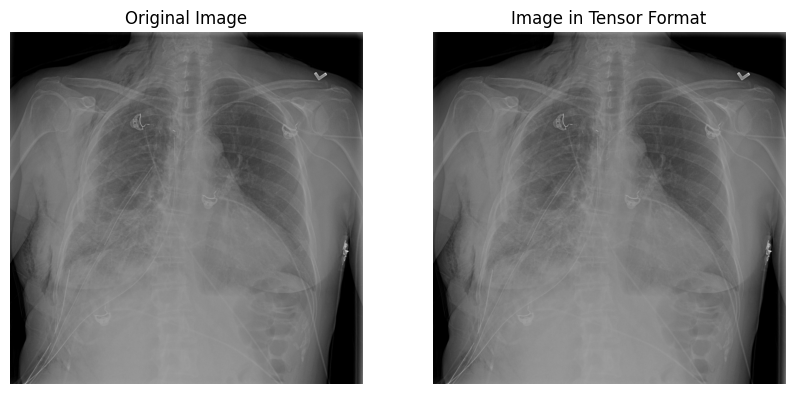


Type of image after all the transformations: <class 'torch.Tensor'>


In [ ]:
from scipy.ndimage import rotate
import matplotlib.image as mpimg
from scipy.ndimage import zoom

# Dataset
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)
val_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)

# Loading an individual image from the dataset
image = train_dataset.__getitem__(11)['image']
# image = cv2.imread("C:/Users/nisha/Desktop/Proper Training of U-Net [reached 4 epochs]/t_mask")

# horizontal flip transformation
flipped_image = np.fliplr(image)

# Step 2: Apply rotation transformation
rotated_image = rotate(image, angle=10, reshape=False)

# Compute the scaling factors
scale_height = 512 / image.shape[0]
scale_width = 512 / image.shape[1]

# resize transformation
resized_image = zoom(image, (scale_height, scale_width, 1))

# Normalize the image
normalized_image = image.astype(np.float32) / 255.0

# Convert to tensor
image_tensor = torch.tensor(image)

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Horizontally Flipped Image')
plt.imshow(flipped_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Rotated Image (10 degrees)')
plt.imshow(rotated_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resized Image (512x512)')
plt.imshow(resized_image)
plt.axis('off')

plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.imshow(image_tensor)
plt.title('Image in Tensor Format')
plt.axis('off')


plt.show()

print(f"\nType of image after all the transformations: {type(image_tensor)}")

In [ ]:
# Train transforms
TFMS = albu.Compose([
    albu.HorizontalFlip(),
    albu.Rotate(10),
    albu.Resize(height=512, width=512),
    albu.Normalize(),
    ToTensorV2(),
],
    is_check_shapes=False,
)

# Test transforms
TEST_TFMS = albu.Compose([
    albu.Resize(height=512, width=512),
    albu.Normalize(),
    ToTensorV2(),
],
    is_check_shapes=False,
)

In [ ]:
# train dataset
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS)
val_dataset   = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS)

In [ ]:
train_dataset.__getitem__(11)['image'].shape

torch.Size([3, 512, 512])

In [ ]:
train_dataset.__len__()

9266

In [ ]:
# # plot one with mask
# visualize(**train_dataset[1])

### Sampler

In [ ]:
class PneumoSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive pneumothorax images must be greater then zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)

    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative

In [ ]:
SAMPLER = PneumoSampler(TRAIN_DF, positive_perc=POSTIVE_PERC)

### DataLoaders

In [ ]:
# dataloaders
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE,
                              shuffle=True if not USE_SAMPLER else False,
                              num_workers=2,
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
print(f"Dataloaders: {train_dataloader , val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d1b66553df0>, <torch.utils.data.dataloader.DataLoader object at 0x7d1b665511e0>)
Length of train dataloader: 1159 batches of 8
length of validation dataloader: 290 batches of 8


### Loss

In this script we use [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) from winning solution but it is also possible to use `MixedLoss` shared below if `USE_CRIT` is set to `False` in CONFIG.

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## 2. Model

In [ ]:
"""Basic U-net model"""
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False, device=DEVICE),
        nn.BatchNorm2d(out_channels, device=DEVICE),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False, device=DEVICE),
        nn.BatchNorm2d(out_channels, device=DEVICE),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, in_channels, out_channels, features = [64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Encoder layers for U-Net
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Decoder layers for U-Net
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2, device=DEVICE))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottom = DoubleConv(features[-1], (features[-1])*2)

    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, device=DEVICE)

  def forward(self, x):
    skip_connections = []
    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottom(x)
    skip_connections = skip_connections[::-1]

    for index in range(0, len(self.ups), 2):
      x = self.ups[index](x)
      skip_connection = skip_connections[index//2]
    # SHOULD CONSIDER PADDING CUZ RESIZING WILL AFFECT ACCURACY even though IT'S NEGLIGIBLE
      if x.shape != skip_connection.shape:
       skip_connection = TF.resize(skip_connection, size = x.shape[2:], antialias=False)
    # Concatenation type skip connection
      concat = torch.cat((skip_connection,x), dim=1)
      x = self.ups[index+1](concat)
    return self.final_conv(x)

In [ ]:
# Input has 3 color channels [RGB] & Output has 1 color channel
# Format NCHW - no. of samples in a mini-batch, no. of color channels, height and width.
model = UNet(in_channels=3, out_channels=1)

### Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

### Training

In [ ]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()

    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_train = []
    batch_train_loss = []

    model = model.to(DEVICE)
    model.train()
    if accumulation_steps > 1:
      optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
      # print(data['image'].shape) -> torch.Size([8, 3, 512, 512])
      # print(data['mask'].shape) -> torch.Size([8, 512, 512])
      batch_count_train.append(b_idx)

      # moves image tensor and mask tensor to gpu
      for key, value in data.items():
        data[key] = value.to(DEVICE)

      if accumulation_steps == 1 and b_idx == 0:
        optimizer.zero_grad()
      out  = model(data['image']) # out.shape = torch.Size([8, 1, 512, 512])
      loss = loss_fn(out, data['mask'].unsqueeze(1)) # mask.shape = torch.Size([8, 1, 512, 512])
      with torch.set_grad_enabled(True):
        loss.backward()
        if (b_idx + 1) % accumulation_steps == 0:
          optimizer.step()
          optimizer.zero_grad()
      losses.update(loss.item(), train_loader.batch_size)

      batch_train_loss.append(losses.avg)
      tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg, batch_count_train, batch_train_loss

In [ ]:
# model.to(DEVICE)
# model.train()
# mask = train_dataset[11]["mask"].unsqueeze(0).unsqueeze(1).float()
# print("Mask Shape: ",mask.shape)
# image = train_dataset[11]["image"].unsqueeze(0)
# print("Image Shape: ",image.shape)
# raw_output = model(image.to(DEVICE))
# print("raw output shape: ", raw_output.shape)
# print("------ Raw Output ------")
# print(raw_output)
# print("------- Pred Probs -------")
# pred_probs = torch.sigmoid(raw_output)
# print(pred_probs)
# print("------- How does the Mask look like? ------")
# print(mask)
# print("-------- pred labels --------")
# pred_labels = torch.round(pred_probs)
# print(pred_labels)

In [ ]:
# plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap = 'gray')
# print(mask.squeeze().shape)
# plt.title(mask);

In [ ]:
# print(pred_labels.squeeze().shape)
# plt.imshow(pred_labels.squeeze().detach().cpu().numpy(), cmap='gray')
# plt.title(pred_labels);

In [ ]:
# mask.squeeze().shape, pred_labels.squeeze().shape

In [ ]:
# torch.flatten(mask.squeeze()).shape, torch.flatten(pred_labels.squeeze().detach().cpu()).shape

In [ ]:
# mask0 = torch.flatten(mask.squeeze())
# pred_labels0 = torch.flatten(pred_labels.squeeze().detach().cpu())
# print(accuracy_fn(mask0 , pred_labels0))

### Evaluation Metric

In [ ]:
def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [ ]:
def evaluate(valid_loader, model, device=DEVICE, metric=dice_metric):
    losses = AverageMeter()
    """variable is named wrongly, there is no concept of loss validation.
       It should be dice_scores cuz in the validation phase, dice score is calculated
       to evaluate the performance of the model. Based on the dice score, early stopping function prevents overfitting.
    """
    # Lists to store batch-to-batch progress details within the epoch while training
    batch_count_val = []
    batch_val_score_values = []

    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.inference_mode():
        for b_idx, data in enumerate(tk0):
          batch_count_val.append(b_idx)
          for key, value in data.items():
            data[key] = value.to(device)
          out   = model(data['image']) # Raw model output
          out   = torch.sigmoid(out) # Prediction probabilities
          dice  = metric(out, data['mask'].unsqueeze(1)).cpu() # mask shape = out shape = torch.Size([8, 1, 512, 512])
          losses.update(dice.mean().item(), valid_loader.batch_size)
          batch_val_score_values.append(losses.avg)
          tk0.set_postfix(dice_score=losses.avg)
    return losses.avg, batch_count_val, batch_val_score_values

In [ ]:
# if PRETRAINED:
#     model.load_state_dict(torch.load(PRETRAINED_PATH))

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)
"""The code you provided defines a learning rate scheduler using the `MultiStepLR` class from PyTorch's `torch.optim.lr_scheduler` module. Here's a breakdown of what it does:

* **`scheduler = torch.optim.lr_scheduler.MultiStepLR(...)`**: This line creates a new learning rate scheduler object.
* **`optimizer`**: This is the optimizer object used for training the model. The scheduler works in conjunction with the optimizer to adjust the learning rate during training.
* **`milestones=[3,5,6,7,8,9,10,11,13,15]`**: This defines a list of epochs (iterations) at which the learning rate will be decreased. In this case, the learning rate will be adjusted at epochs 3, 5, 6, 7, 8, 9, 10, 11, 13, and 15.
* **`gamma=0.75`**: This parameter defines the factor by which the learning rate will be multiplied after each milestone epoch. Here, `gamma` is set to 0.75, which means the learning rate will be reduced by 25% (1 - 0.75) at each milestone epoch.

**How it Works:**

* During training, the `scheduler.step()` method is called after each epoch (typically within the main training loop).
* Based on the current epoch number, the scheduler checks if it coincides with any of the milestones defined in the `milestones` list.
* If a milestone is reached, the scheduler updates the learning rate of the optimizer by multiplying it by `gamma`. In this case, the learning rate will be decreased by 25%.
* This way, the learning rate gradually decreases throughout training, which can help the model converge and prevent overfitting.

**Additional Notes:**

* `MultiStepLR` is a simple and effective scheduler for learning rate decay. However, there are other more sophisticated schedulers available in PyTorch that can adapt the learning rate more dynamically based on the training progress.
* The choice of milestones and `gamma` value depends on the specific problem and dataset you're working with. Experimentation might be needed to find the optimal configuration for your task."""

"The code you provided defines a learning rate scheduler using the `MultiStepLR` class from PyTorch's `torch.optim.lr_scheduler` module. Here's a breakdown of what it does:\n\n* **`scheduler = torch.optim.lr_scheduler.MultiStepLR(...)`**: This line creates a new learning rate scheduler object.\n* **`optimizer`**: This is the optimizer object used for training the model. The scheduler works in conjunction with the optimizer to adjust the learning rate during training.\n* **`milestones=[3,5,6,7,8,9,10,11,13,15]`**: This defines a list of epochs (iterations) at which the learning rate will be decreased. In this case, the learning rate will be adjusted at epochs 3, 5, 6, 7, 8, 9, 10, 11, 13, and 15.\n* **`gamma=0.75`**: This parameter defines the factor by which the learning rate will be multiplied after each milestone epoch. Here, `gamma` is set to 0.75, which means the learning rate will be reduced by 25% (1 - 0.75) at each milestone epoch.\n\n**How it Works:**\n\n* During training, the 

### Train model

In [ ]:
criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION
#criterion = MixedLoss(10.0, 2.0)
es = EarlyStopping(patience=10, mode='max')

In [ ]:
criterion

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

In [ ]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU

# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [ ]:
# def eval_confusion_matrix(valid_loader, model, device=DEVICE, batch_files=batch_files):
#     roc = []
#     model = model.to(device)
#     model.eval()
#     tk0 = tqdm(valid_loader, total=len(valid_loader))
#     with torch.no_grad():
#         for b_idx, data in enumerate(tk0):
#             for key, value in data.items():
#                 data[key] = value.to(device)
#             out   = model(data['image'])

#             # N-modifications
#             batch_files.append((out.cpu().detach().numpy(), (data["mask"]).unsqueeze(1).cpu().detach().numpy()))
#             # - - - - - - - - - - - - - - - -

In [ ]:
# def plot_roc(roc):
#   x_values = [x for x,y in roc]
#   y_values = [y for x,y in roc]
#   plt.style.use("seaborn-v0_8")
#   fig, ax = plt.subplots()
#   ax.plot(x_values, y_values)
#   ax.set_title("ROC Curve", fontsize=20)
#   ax.set_xlabel("false-positive-rate", fontsize=14)
#   ax.set_ylabel("true-positive-rate", fontsize=14)
#   ax.tick_params(axis='both', labelsize=14)
#   plt.show()

In [ ]:
MODEL_PATH = Path("/content/drive/MyDrive/Saved Models/Model_22_02_2024.tar")
#Resume Training
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [ ]:
MODEL_PATH = Path("/content/drive/MyDrive/Saved Models/Model_22_02_2024.tar")
#Resume Training
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# epoch = checkpoint["Epoch"]
# train_loss_per_epoch = checkpoint["Train Loss"]

model.train()
# Lists to store epoch-to-epoch progress details
epoch_count = []
loss_values = []
val_score_values = []

# Training Loop
for epoch in range(EPOCHS):
    epoch_count.append(epoch)
    loss, batch_count_train, batch_train_loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
    loss_values.append(loss)

    dice, batch_count_val, batch_val_score_values = evaluate(val_dataloader, model, metric=metric) # Evaluates model performance by calculating the dice coefficient/ F1 score/ dice score
    val_score_values.append(dice)
    scheduler.step() # Decreases LR by 25% when current epoch in milestones.
    print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")

    """" If it is necessary to save model's state dict as checkpoint, do the essential changes
         in Early Stopping class."""

    es(dice, model, model_path=f"/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
    best_model = f"/content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
    if es.early_stop:
        print('\n\n -------------- EARLY STOPPING -------------- \n\n')
        break

100%|██████████| 290/290 [00:55<00:00,  5.20it/s, dice_score=0.049]


EPOCH: 0, TRAIN LOSS: 0.7400575431212687, VAL DICE: 0.04900789770843654
Validation score improved (0.03294069796292802 --> 0.04900789770843654). Model saved at at /content/drive/MyDrive/Colab_Notebooks/datasets/archive_png_siim_acr/bst_model512_fold4_0.049.bin!


In [ ]:
print(type(batch_train_loss[1]))

<class 'float'>


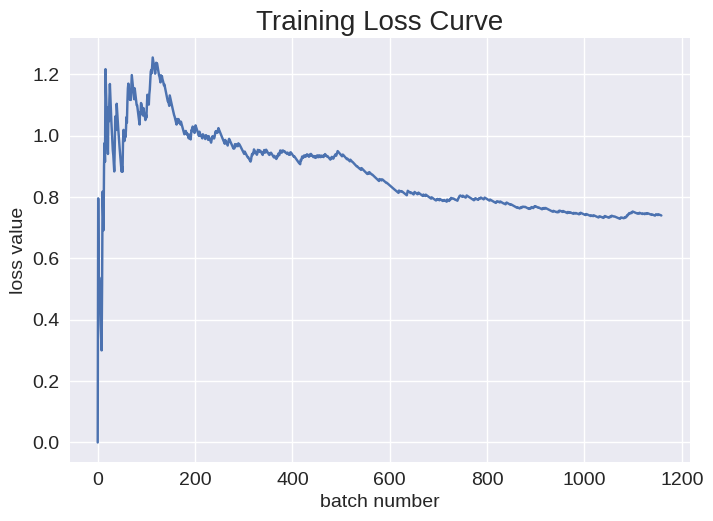

In [ ]:
# Visualization of batch-to-batch progress while training
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots()
ax.plot(batch_count_train, batch_train_loss)
ax.set_title("Training Loss Curve", fontsize=20)
ax.set_xlabel("batch number", fontsize=14)
ax.set_ylabel("loss value", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.show()

0.22131642699241638


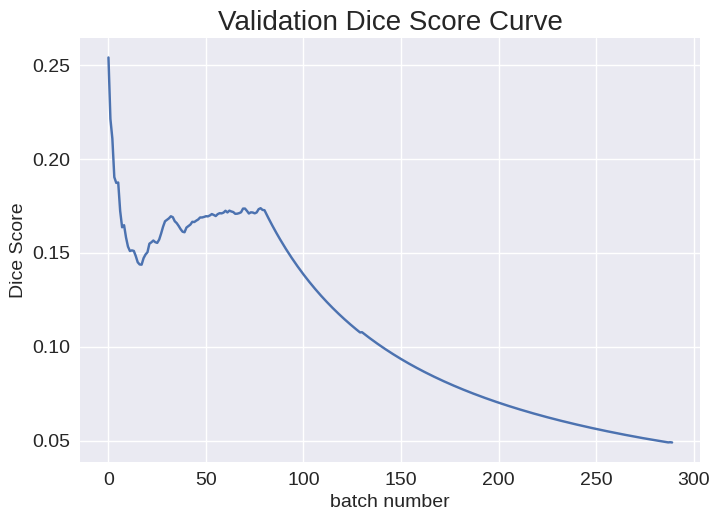

In [ ]:
# Visualization of batch-to-batch progress while validation
print(batch_val_score_values[1])
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots()
ax.plot(batch_count_val, batch_val_score_values)
ax.set_title("Validation Dice Score Curve", fontsize=20)
ax.set_xlabel("batch number", fontsize=14)
ax.set_ylabel("Dice Score", fontsize=14)
ax.tick_params(axis='both', labelsize=14)
plt.show()

# Testing Loop with external dataset to check GENERALIZABILITY of the model.


In [ ]:
# Testing Loop with external dataset to check GENERALIZABILITY of the model.


# Saving Model as Checkpoint in .tar format

In [ ]:
MODEL_PATH = Path("/content/drive/MyDrive/Saved Models/Model_04_03_2024.tar")
torch.save({"Epoch": 0, "Train Loss": loss, "Validation Dice Score": dice, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict()}, MODEL_PATH)

In [ ]:
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["Epoch"]
train_loss_per_epoch = checkpoint["Train Loss"]

# Sample Predictions after 1 epoch

In [ ]:
model.to(DEVICE)
model.eval()
mask = train_dataset[2128]["mask"].unsqueeze(0).unsqueeze(1).float()
print("Mask Shape: ",mask.shape)
image = train_dataset[2128]["image"].unsqueeze(0)
print("Image Shape: ",image.shape)
raw_output = model(image.to(DEVICE))
print("raw output shape: ", raw_output.shape)
print("------ Raw Output ------")
print(raw_output)
print("------- Pred Probs -------")
pred_probs = torch.sigmoid(raw_output)
print(pred_probs)
print("------- How does the Mask look like? ------")
print(mask)
print("-------- pred labels --------")
pred_labels = torch.round(pred_probs)
print(pred_labels)

Mask Shape:  torch.Size([1, 1, 512, 512])
Image Shape:  torch.Size([1, 3, 512, 512])
raw output shape:  torch.Size([1, 1, 512, 512])
------ Raw Output ------
tensor([[[[-1.1592, -1.4239, -1.1918,  ..., -1.4759, -1.0300, -0.5388],
          [-0.5292, -1.3738, -1.5623,  ..., -1.6544, -1.0337, -0.9363],
          [-0.7236, -0.7984, -1.3921,  ..., -1.4584, -1.0715, -1.0310],
          ...,
          [-0.7959, -0.6220, -0.7714,  ..., -0.5883, -0.4137, -0.7312],
          [-0.5845, -0.4826, -0.8784,  ..., -0.8689, -0.5380, -0.5670],
          [-0.9723, -1.1641, -0.6526,  ..., -0.9459, -0.7301, -0.8147]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)
------- Pred Probs -------
tensor([[[[0.2388, 0.1941, 0.2329,  ..., 0.1860, 0.2631, 0.3685],
          [0.3707, 0.2020, 0.1733,  ..., 0.1605, 0.2624, 0.2816],
          [0.3266, 0.3104, 0.1991,  ..., 0.1887, 0.2551, 0.2629],
          ...,
          [0.3109, 0.3493, 0.3162,  ..., 0.3570, 0.3980, 0.3249],
          [0.3579, 0.3816, 0.2

In [ ]:
plt.style.use("classic")

torch.Size([512, 512])


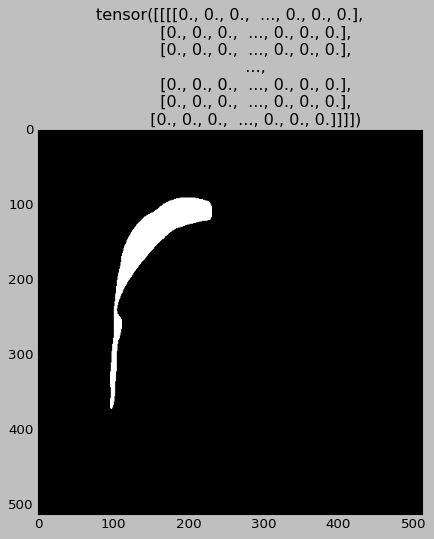

In [ ]:
plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap = 'gray')
print(mask.squeeze().shape)
plt.title(mask);

torch.Size([512, 512])


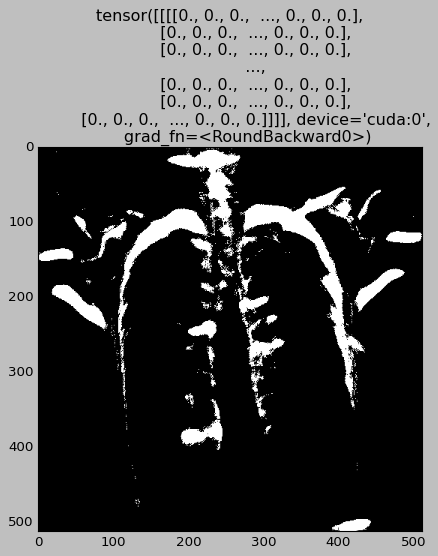

In [ ]:
print(pred_labels.squeeze().shape)
plt.imshow(pred_labels.squeeze().detach().cpu().numpy(), cmap='gray')
plt.title(pred_labels);

In [ ]:
print(type(pred_probs), type(mask))
print(pred_probs.shape, mask.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])


In [ ]:
Dice = metric(pred_probs.detach().cpu(), mask).item()
print(f"Dice score: {Dice}")

Dice score: 0.16267405450344086
